<a href="https://colab.research.google.com/github/ndtuan10/SpeechRecognition-Tacotron2/blob/main/Speech-recognition%20using%20pre-trained%20(Tacotron2%2BWaveGlow).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **BÁO CÁO THỰC HÀNH**

**Môn : Tổng hợp giọng nói - CS535.L11.KHCL**

- Nội dung thực hành: Sử dụng các mô hình để tổng hợp giọng nói.
- Link dataset: https://keithito.com/LJ-Speech-Dataset/
- Link tham khảo:
    - https://github.com/NVIDIA/tacotron2
    - https://github.com/NVIDIA/waveglow


Giáo viên : 
  + ThS. Trịnh Quốc Sơn

Thành viên :

  + Ngô Đức Tuấn (18520186)  
  + Lê Hoàng Long (18521027)

## **1. Cài đặt**

In [ ]:
import os
import torch
import tensorflow as tf
import matplotlib
import matplotlib.pylab as plt
import IPython.display as ipd
import numpy as np
print('''
  Phiên bản của các thư viện :
    + torch : {0}
    + Tensorflow : {1}
    + matplotlib : {2}
    + numpy : {3}
'''.format(torch.__version__, tf.__version__,  matplotlib.__version__, np.__version__))

# sao chép tacotron2 repository trên git
! git clone https://github.com/NVIDIA/tacotron2.git
! cd {tacotron2}
! pip install -q librosa unidecode


  Phiên bản của các thư viện :
    + torch : 1.7.0+cu101
    + Tensorflow : 1.15.2
    + matplotlib : 3.2.2
    + numpy : 1.19.5

fatal: destination path 'tacotron2' already exists and is not an empty directory.
/bin/bash: line 0: cd: {tacotron2}: No such file or directory


## **2. Tải các mô hình pretrained**

In [ ]:
def download_from_google_drive(file_id, file_name):
  # download a file from the Google Drive link
  !rm -f ./cookie
  !curl -c ./cookie -s -L "https://drive.google.com/uc?export=download&id={file_id}" > /dev/null
  confirm_text = !awk '/download/ {print $NF}' ./cookie
  confirm_text = confirm_text[0]
  !curl -Lb ./cookie "https://drive.google.com/uc?export=download&confirm={confirm_text}&id={file_id}" -o {file_name}

# download mô hình Tacotron2 pretrained
tacotron2_pretrained_model = 'tacotron2_statedict.pt'
download_from_google_drive('1c5ZTuT7J08wLUoVZ2KkUs_VdZuJ86ZqA', tacotron2_pretrained_model)

# download mô hình WaveGlow pretrained
waveglow_pretrained_model = 'waveglow_old.pt'
download_from_google_drive('1WsibBTsuRg_SF2Z6L6NFRTT-NjEy1oTx', waveglow_pretrained_model)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   408    0   408    0     0    755      0 --:--:-- --:--:-- --:--:--   754
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100  107M    0  107M    0     0  39.0M      0 --:--:--  0:00:02 --:--:--  108M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   408    0   408    0     0   1123      0 --:--:-- --:--:-- --:--:--  1120
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  644M    0  644M    0     0   122M      0 --:--:--  0:00:05 --:--:--  169M


## 3. **Chạy Tacotron2 and Waveglow**
- Code được trích dẫn từ nguồn từ https://github.com/NVIDIA/tacotron2/blob/master/inference.ipynb và được cập nhật cho Colab.

In [ ]:
from hparams import create_hparams
from model import Tacotron2
from layers import TacotronSTFT
from audio_processing import griffin_lim
from text import text_to_sequence
from denoiser import Denoiser

def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='bottom', 
                       interpolation='none', cmap='viridis')

torch.set_grad_enabled(False)
        
# Khởi tạo Tacotron2 với mô hình pretrained
hparams = create_hparams()
hparams.sampling_rate = 22050
model = Tacotron2(hparams)
model.load_state_dict(torch.load(tacotron2_pretrained_model)['state_dict'])
_ = model.cuda().eval()#.half()

# Khởi tạo WaveGlow với mô hình pretrained
# waveglow = torch.load(waveglow_pretrained_model)['model']
# WORKAROUND for: https://github.com/NVIDIA/tacotron2/issues/182
import json
from glow import WaveGlow
waveglow_config = json.load(open('%s/waveglow/config.json' % project_name))['waveglow_config']
waveglow = WaveGlow(**waveglow_config)
waveglow.load_state_dict(torch.load(waveglow_pretrained_model)['model'].state_dict())
_ = waveglow.cuda().eval()#.half()
for k in waveglow.convinv:
    k.float()
denoiser = Denoiser(waveglow)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



/usr/local/lib/python3.6/dist-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.conv.ConvTranspose1d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv1d' has changed. you can retrieve the original source code by accessing the object's source attribute or

## **4. Tổng hợp một văn bản bất kỳ**
- Nhập đoạn văn bản trong phần`TEXT`

In [ ]:
TEXT = "My love for you is like the raging sea. So powerful and deep it will forever be. Through storm, wind, and heavy rain. It will withstand every pain."

- Ta chuyển đoạn văn bản trên thành biểu đồ phổ mel bằng Tacotron2 và vẽ biểu
đồ:

Warning! Reached max decoder steps


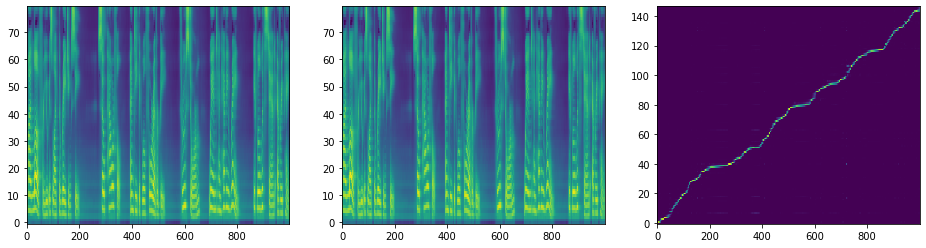

In [ ]:
sequence = np.array(text_to_sequence(TEXT, ['english_cleaners']))[None, :]
sequence = torch.autograd.Variable(torch.from_numpy(sequence)).long()
sequence = sequence.cuda()

mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)
plot_data((mel_outputs.data.cpu().numpy()[0],
           mel_outputs_postnet.data.cpu().numpy()[0],
           alignments.data.cpu().numpy()[0].T))

- Cuối cùng, ta chuyển đổi quang phổ mel được tạo thành âm thanh:

In [ ]:
audio = waveglow.infer(mel_outputs_postnet, sigma=0.666)
ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate)